# Solar Simulation Application with National Solar Radiance Database and System Advisor Models

- NSRDB Website: https://nsrdb.nrel.gov
- Get NSRDB API Key: https://developer.nrel.gov/signup/
- Register to use SAM: https://sam.nrel.gov
- Download the SAM Software Development Kit (SDK): https://sam.nrel.gov/sdk
- NSRDB download instructions using API: https://developer.nrel.gov/docs/solar/nsrdb/
- PySAM module references: https://nrel-pysam.readthedocs.io/en/main/py-modindex.html

<div>
<img src="SolarPanels_image.jpg" width="600"/>
</div>

In [20]:
# import libraries used in this notebook 
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import json
from matplotlib import pyplot as plt

# pip install nrel-pysam
import PySAM.PySSC as pssc
import site
site.addsitedir('/Applications/sam-sdk-2015-6-30-r3/languages/python/')

from urllib.error import HTTPError
from ipywidgets import interact, Dropdown, Layout, Text
from itertools import product

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Create Dropdown Interfaces

In [25]:
style = {'description_width': '200px'}
layout = Layout(width='325px')

InOutChoice = Dropdown(description = 'Inside or Outside the US', style=style, layout=layout)
Area = Dropdown(description = 'Area:', style=style, layout=layout)
StartYear = Dropdown(description = 'Start Year:', style=style, layout=layout)
EndYear = Dropdown(description = 'End Year:', style=style, layout=layout)
Interval = Dropdown(description = 'Temporal Resolution (in Minutes):', style=style, layout=layout)
Capacity = Dropdown(description = 'Your System Capacity (in MW):', style=style, layout=layout)

### Define relationship between input variables

In [26]:
with open('DatasetInfo.json') as f:
    DatasetInfo = json.load(f)
with open('API_Key.json') as f:
    Cred = json.load(f)


GeoInfo = pd.read_json('Areas_avg_latLong.json')
InUSName = GeoInfo.state.tolist()[:-4]
OutUSName = GeoInfo.state.tolist()[-4:]

InOutArea = {'United States': InUSName, 'International': OutUSName}

OutUSAreaYear = {}
OutUSAreaRes = {}
for key, value in DatasetInfo['OutTheUS'].items():
    OutUSAreaYear[key] = [str(i) for i in range(int(value['StartYear']), int(value['EndYear']) + 1)]
    OutUSAreaRes[key] = value['Resolution']

InUSAreaYear = {}
a = [str(i) for i in range(int(DatasetInfo["InTheUS"]["LowResoluion"]["StartYear"]), int(DatasetInfo["InTheUS"]["LowResoluion"]["EndYear"]) + 1)]

def Convert(tup, di):
    for a, b in tup:
        di.setdefault(a, []).append(b)
    return di

EmptyDict = {}
InUSAreaYear = Convert([i for i in product(InUSName, [str(i) for i in range(int(DatasetInfo["InTheUS"]["LowResoluion"]["StartYear"]), int(DatasetInfo["InTheUS"]["LowResoluion"]["EndYear"]) + 1)])], EmptyDict)    

# merge two dictionaries
AllAreaYear = OutUSAreaYear | InUSAreaYear



### Create function to fetch urls given user inputs

In [4]:
def get_url_from_NSRDB():
    
    UrlList = []
    global lat, lon
    for year in range(int(StartYear.value), EndYear.value+1):

        # url parameters
        lat = GeoInfo[GeoInfo['state'] == Area.value]['latitude'].values[0]
        lon = GeoInfo[GeoInfo['state'] == Area.value]['longitude'].values[0]
        api_key = Cred["key"]
        year = year
        interval = str(Interval.value)
        leap_year = 'false'
        utc = 'false'
        your_name = 'Justin+Lin'
        reason_for_use = 'beta+testing'
        your_affiliation = 'HTF'
        your_email = 'slin@wvhtf.org'
        mailing_list = 'false'
        if Area.value not in OutUSName:
            dataset = DatasetInfo['InTheUS']['HighResolution']['Dataset'] if (Interval.value == "5") or (Interval.value == "15") else DatasetInfo['InTheUS']['LowResoluion']['Dataset']
            attributes = DatasetInfo['InTheUS']['HighResolution']['Attributes']
        else:
            dataset = ', '.join(map(str, [v['Dataset'] for k, v in DatasetInfo['OutTheUS'].items() if Area.value == k]))
            attributes = ', '.join(map(str, [v['Attributes'] for k, v in DatasetInfo['OutTheUS'].items() if Area.value == k]))
        
        url = f"https://developer.nrel.gov/api/nsrdb/v2/solar/{dataset}.csv?"\
                f"wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap_year}&interval={interval}"\
                f"&utc={utc}&full_name={your_name}&email={your_email}&affiliation={your_affiliation}"\
                f"&mailing_list={mailing_list}&reason={reason_for_use}&api_key={api_key}&attributes={attributes}"
        
        UrlList.append(url)

    return UrlList


### Create function to run solar simulation through PySAM modules

In [5]:
def solar_power_simulation():
    
    global final_data
    appended_data = []

    for url in get_url_from_NSRDB():
        
        info = pd.read_csv(url, nrows=1)
        timezone, elevation = info['Local Time Zone'], info['Elevation']
    
        df = pd.read_csv(url, skiprows=2)

        # SAM Model for solar simulation
        ssc = pssc.PySSC()
        
        # Resource inputs for SAM model:
        # Must be byte strings
        wfd = ssc.data_create()
        ssc.data_set_number(wfd, b'lat', lat)
        ssc.data_set_number(wfd, b'lon', lon)
        ssc.data_set_number(wfd, b'tz', timezone)
        ssc.data_set_number(wfd, b'elev', elevation)
        ssc.data_set_array(wfd, b'year', df['Year'])
        ssc.data_set_array(wfd, b'month', df['Month'])
        ssc.data_set_array(wfd, b'day', df['Day'])
        ssc.data_set_array(wfd, b'hour', df['Hour'])
        ssc.data_set_array(wfd, b'minute', df['Minute'])
        ssc.data_set_array(wfd, b'dn', df['DNI'])
        ssc.data_set_array(wfd, b'df', df['DHI'])
        ssc.data_set_array(wfd, b'wspd', df['Wind Speed'])
        if Area.value == 'Puerto Rico':
            ssc.data_set_array(wfd, b'tdry', df['Air Temperature'])
        else:
            ssc.data_set_array(wfd, b'tdry', df['Temperature'])
    
        # Create SAM compliant object  
        dat = ssc.data_create()
        ssc.data_set_table(dat, b'solar_resource_data', wfd)
        ssc.data_free(wfd)
    
        # Specify the system Configuration
        # Set system capacity in MW
        ssc.data_set_number(dat, b'system_capacity', Capacity.value)
        # Set DC/AC ratio (or power ratio). See https://sam.nrel.gov/sites/default/files/content/virtual_conf_july_2013/07-sam-virtual-conference-2013-woodcock.pdf
        ssc.data_set_number(dat, b'dc_ac_ratio', 1.1)
        # Set tilt of system in degrees
        ssc.data_set_number(dat, b'tilt', 25)
        # Set azimuth angle (in degrees) from north (0 degrees)
        ssc.data_set_number(dat, b'azimuth', 180)
        # Set the inverter efficency
        ssc.data_set_number(dat, b'inv_eff', 96)
        # Set the system losses, in percent
        ssc.data_set_number(dat, b'losses', 14.0757)
        # Specify fixed tilt system (0=Fixed, 1=Fixed Roof, 2=1 Axis Tracker, 3=Backtracted, 4=2 Axis Tracker)
        ssc.data_set_number(dat, b'array_type', 0)
        # Set ground coverage ratio
        ssc.data_set_number(dat, b'gcr', 0.4)
        # Set constant loss adjustment
        ssc.data_set_number(dat, b'adjust:constant', 0)
    
        # execute and put generation results back into dataframe
        mod = ssc.module_create(b'pvwattsv5')
        ssc.module_exec(mod, dat)
        df[b'generation'] = np.array(ssc.data_get_array(dat, b'gen'))
        
        # free the memory
        ssc.data_free(dat)
        ssc.module_free(mod)
        
        appended_data.append(df)
        
    final_data = pd.concat(appended_data)
    
    print(f'\033[1mThis dataset has {final_data.shape[0]} rows and {final_data.shape[1]} columns\033[0m')
    return final_data.head(20)

### Create functions to visualize the results 

In [6]:
# create chart to see daily changes for GHI, DNI, DHI, and generation
def daily_plot(df):
    
    plt.style.use('Solarize_Light2')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    if (Area.value == 'Vietnam') or (Area.value == 'Philippines'):
        df = df.groupby('Hour').sum()[['GHI', 'DNI', 'DHI', b'generation']]
        df[['GHI', 'DNI', 'DHI']].plot(ax=ax, figsize=(15,8), style={'DNI': 'c-o', 'DHI': '-o', 'GHI': 'r-o'}, legend=False)
    else:
        df = df.groupby('Hour').sum()[['GHI', 'DNI', 'DHI', 'Solar Zenith Angle', b'generation']]
        df[['GHI', 'DNI', 'DHI', 'Solar Zenith Angle']].plot(ax=ax, figsize=(15,8), style={'Solar Zenith Angle': 'm-o', 'DNI': 'c-o', 'DHI': 'y-o', 'GHI': 'r-o'}, legend=False)
    df[b'generation'].plot(ax=ax2, style={b'generation': '-D'})
    ax.set_ylabel('W/m2')
    ax2.set_ylabel('kW')
    ax.grid()
    ax.legend(loc=2, ncol=5, frameon=False)
    ax2.legend(loc=1, frameon=False)
    ax.set_xticks([i for i in range(1, 25, 2)])
    if StartYear.value != EndYear.value:
        plt.title(f'Aggregated Daily solar simulation results with {Interval.value} min temporal resolution in {Area.value} from {StartYear.value} to {EndYear.value}')
    else:
        plt.title(f'Aggregated Daily solar simulation results with {Interval.value} min temporal resolution in {Area.value} in {StartYear.value}')


In [7]:
# create chart to see monthly changes for GHI and generation
def monthly_plot(df):
    
    plt.style.use('Solarize_Light2')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    df = df.groupby('Month').sum()[['GHI', b'generation']]
    df['GHI'].plot(ax=ax, figsize=(15,8), color = 'tab:red', style={'GHI': '-o'}, legend=False)
    df[b'generation'].plot(ax=ax2, style={b'generation': '-D'})
    ax.set_ylabel('W/m2')
    ax2.set_ylabel('kW')
    ax.grid()
    ax.legend(loc=2, ncol=5, frameon=False)
    ax2.legend(loc=1, frameon=False)
    ax.set_xticks(df.index)
    if StartYear.value != EndYear.value:
        plt.title(f'Aggregated Monthly solar simulation results with {Interval.value} min temporal resolution in {Area.value} from {StartYear.value} to {EndYear.value}')
    else:
        plt.title(f'Aggregated Monthly solar simulation results with {Interval.value} min temporal resolution in {Area.value} in {StartYear.value}')

In [8]:
# create chart to see yearly changes for GHI and generation
def yearly_plot(df):
    
    plt.style.use('Solarize_Light2')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    df = df.groupby('Year').sum()[['GHI', b'generation']]
    df['GHI'].plot(ax=ax, figsize=(15,8), color = 'tab:red', style = {'GHI' : '-o'}, legend=False)
    df[b'generation'].plot(ax=ax2, style={b'generation': '-D'})
    ax.grid()
    ax.set_ylabel('W/m2')
    ax2.set_ylabel('kW')
    ax.legend(loc=2, ncol=5, frameon=False)
    ax2.legend(loc=1, frameon=False)
    ax.set_xticks(df.index)
    if StartYear.value != EndYear.value:
        plt.title(f'Aggregated Yearly solar simulation results with {Interval.value} min temporal resolution in {Area.value} from {StartYear.value} to {EndYear.value}')
    else:
        plt.title(f'Aggregated Yearly solar simulation results with {Interval.value} min temporal resolution in {Area.value} in {StartYear.value}')

### User Interface for parameters input

In [9]:
@interact(inout = InOutChoice, area = Area, start = StartYear, end = EndYear, interval = Interval, capacity = Capacity)
def print_option(inout, area, start, end, interval, capacity):
    try:
        InOutChoice.options = ['United States', 'International']
        Area.options = InOutArea[inout]
        StartYear.options = AllAreaYear[Area.value]
        EndYear.options = [i for i in range(int(StartYear.value), int(AllAreaYear[Area.value][-1]) + 1)]
        if (StartYear.value >= DatasetInfo['InTheUS']['HighResolution']['StartYear']) and (inout == 'United States'):
            resolution = DatasetInfo["InTheUS"]["HighResolution"]["Resolution"]
        elif inout == 'United States':
            resolution = DatasetInfo["InTheUS"]["LowResoluion"]["Resolution"]
        else:
            resolution = OutUSAreaRes[Area.value]
        Interval.options = resolution
        Capacity.options = [i / 10 for i in range(1, 101)]
        
        print(inout, area, start, end, interval, capacity)
    
    except KeyError:
        print('Please choose an area')
    except TypeError: 
        print('Please choose a start year')

interactive(children=(Dropdown(description='In/Out:', layout=Layout(width='325px'), options=('United States', …

### Fetch urls 

In [15]:
get_url_from_NSRDB()

['https://developer.nrel.gov/api/nsrdb/v2/solar/puerto-rico-download.csv?wkt=POINT(-66.664513%2018.200178)&names=2007&leap_day=false&interval=30&utc=false&full_name=Justin+Lin&email=slin@wvhtf.org&affiliation=HTF&mailing_list=false&reason=beta+testing&api_key=2aD0f1cpYYogKvIhgzCCEsuBHnVvfGhcaItjJnAU&attributes=ghi,dhi,dni,wind_speed,air_temperature,solar_zenith_angle',
 'https://developer.nrel.gov/api/nsrdb/v2/solar/puerto-rico-download.csv?wkt=POINT(-66.664513%2018.200178)&names=2008&leap_day=false&interval=30&utc=false&full_name=Justin+Lin&email=slin@wvhtf.org&affiliation=HTF&mailing_list=false&reason=beta+testing&api_key=2aD0f1cpYYogKvIhgzCCEsuBHnVvfGhcaItjJnAU&attributes=ghi,dhi,dni,wind_speed,air_temperature,solar_zenith_angle',
 'https://developer.nrel.gov/api/nsrdb/v2/solar/puerto-rico-download.csv?wkt=POINT(-66.664513%2018.200178)&names=2009&leap_day=false&interval=30&utc=false&full_name=Justin+Lin&email=slin@wvhtf.org&affiliation=HTF&mailing_list=false&reason=beta+testing&api_

### Run simulations

In [21]:
solar_power_simulation()

This dataset has 70080 rows and 12 columns


,Year,Month,Day,Hour,Minute,GHI,DHI,DNI,Wind Speed,Air Temperature,Solar Zenith Angle,b'generation'
0,2007,1,1,0,0,0,0,0,0.5,21,89.00,0.000000
1,2007,1,1,0,30,0,0,0,0.5,21,89.00,0.000000
2,2007,1,1,1,0,0,0,0,0.5,21,89.00,0.000000
3,2007,1,1,1,30,0,0,0,0.5,21,89.00,0.000000
4,2007,1,1,2,0,0,0,0,0.5,21,89.00,0.000000
5,2007,1,1,2,30,0,0,0,0.5,21,89.00,0.000000
6,2007,1,1,3,0,0,0,0,0.5,21,89.00,0.000000
7,2007,1,1,3,30,0,0,0,0.5,21,89.00,0.000000
8,2007,1,1,4,0,0,0,0,0.5,21,89.00,0.000000
9,2007,1,1,4,30,0,0,0,0.5,21,89.00,0.000000


### Visualization for the simulation results aggregated daily monthly yearly

Differences Between DNI, DHI, GHI:
- Direct Normal Irradiance (DNI) is the amount of solar radiation received per unit area by a surface that is always held perpendicular (or normal) to the rays that come in a straight line from the direction of the sun at its current position in the sky. Typically, you can maximize the amount of irradiance annually received by a surface by keeping it normal to incoming radiation. This quantity is of particular interest to concentrating solar thermal installations and installations that track the position of the sun.

- Diffuse Horizontal Irradiance (DHI) is the amount of radiation received per unit area by a surface (not subject to any shade or shadow) that does not arrive on a direct path from the sun, but has been scattered by molecules and particles in the atmosphere and comes equally from all directions.

- Global Horizontal Irradiance (GHI) is the total amount of shortwave radiation received from above by a surface horizontal to the ground. This value is of particular interest to photovoltaic installations and includes both Direct Normal Irradiance (DNI) and Diffuse Horizontal Irradiance (DHI).

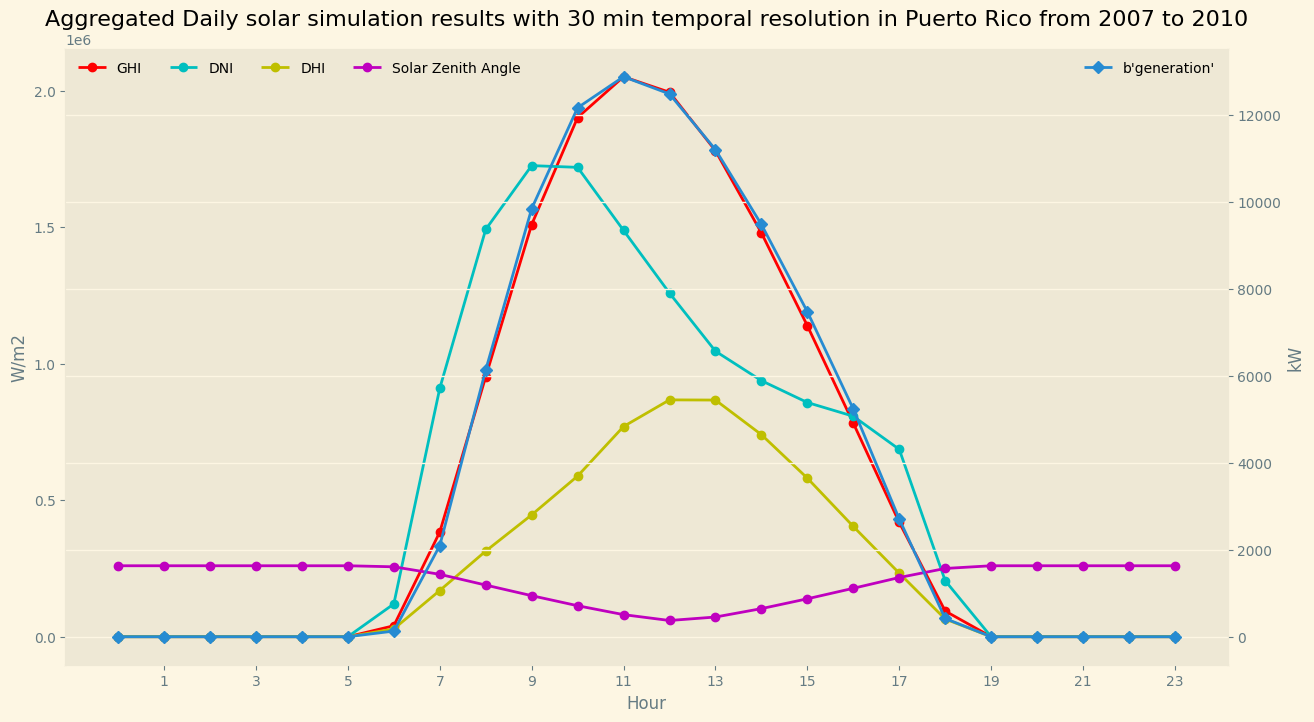

In [22]:
daily_plot(final_data)

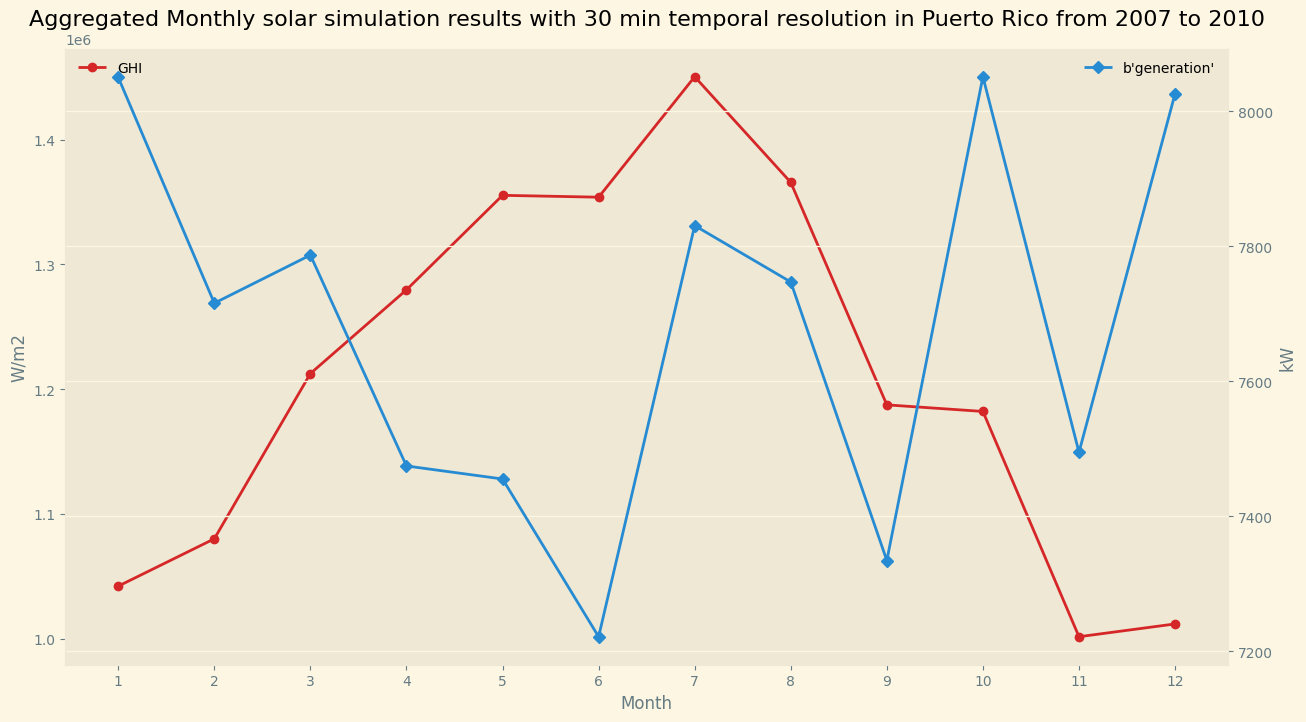

In [23]:
monthly_plot(final_data)

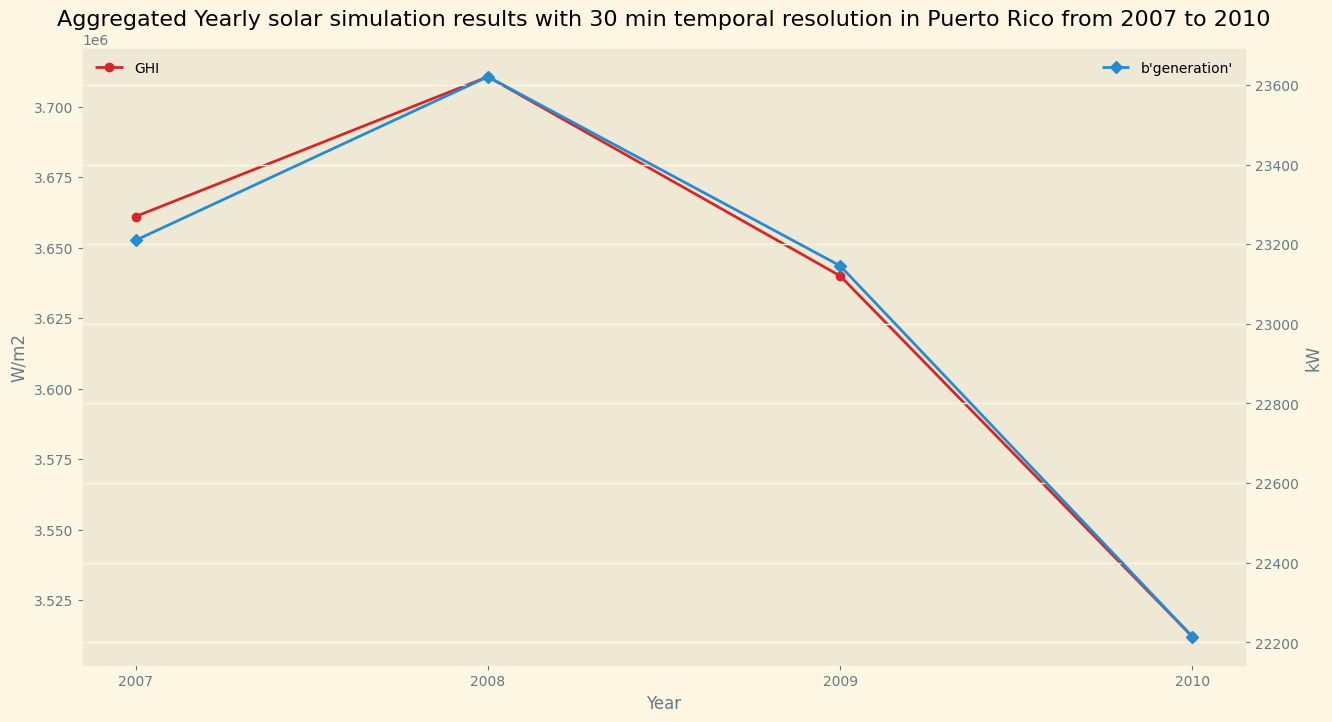

In [24]:
yearly_plot(final_data)